In [317]:
# Import libraries
%load_ext autoreload
%autoreload 2

# from pulse_lib.pickle_parse import *
# from pulse_lib.phase_calibration import *

from qick import *
import Pyro4
import pickle
%pylab inline

# Pyro communicates with board
Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION=4

# Static IP proxy
ns_host = "192.168.2.99"
ns_port = 8888
proxy_name = "myqick"

# QICK object
ns = Pyro4.locateNS(host=ns_host, port=ns_port)
soc = Pyro4.Proxy(ns.lookup(proxy_name))
soccfg = QickConfig(soc.get_cfg())
out_chs = [0,1]
print(soccfg)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib

QICK configuration:

	Board: RFSoC4x2

	Software version: 0.2.267
	Firmware timestamp: Wed Sep  6 18:49:29 2023

	Global clocks (MHz): tProcessor 409.600, RF reference 491.520

	2 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 0, blk 0 is DAC_B
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 0 is DAC_A

	2 readout channels:
	0:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by output 7, pin 14, feedback

In [372]:
f0_start=100
f0_step=1
expts=100
# expts=1

f0_v = np.arange(0,expts)*f0_step+f0_start

f0_v = soccfg.adcfreq(f0_v, gen_ch=0, ro_ch=0)
# f0_v = soccfg.adcfreq([100.0], gen_ch=0, ro_ch=0)

def calculate_phase(d):
    [xi,xq] = d
    x = xi +1j*xq

    # Average to improve calibration.
    xavg = np.mean(x)

    # Calculate calibration phase.
    fi = np.remainder(np.angle(xavg,deg=True)+360,360)
    return [fi, np.abs(xavg), np.std(x)]

def print_results(res):
    print("freq_i = %f MHz, "%(f0) +
         "phi_i = (%.2f, %.2f) deg, " % tuple([res[i][0] for i in range(2)]) +
         "mag = (%.2f, %.2f), " % tuple([res[i][1] for i in range(2)]) +
         "RMS = (%.2f, %.2f) ADU" % tuple([res[i][2] for i in range(2)]))
#     print("freq_i = %f MHz, phi_i = (%.2f, %.2f) deg, mag = (%.2f, %.2f), RMS = (%.2f, %.2f) ADU" %(f0,*out_array,*A,*xrms))

In [373]:
class SingleFreqProgram(AveragerProgram):
    def __init__(self,soccfg, cfg):
        super().__init__(soccfg, cfg)

    def initialize(self):
        cfg=self.cfg   
        
        # configure the readout lengths and downconversion frequencies
        for ch in range(2):
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"])

        idata = 30000*np.ones(16*cfg["length"])

        for ch in self.cfg['out_ch']:
            self.declare_gen(ch=ch, nqz=1)
            self.add_pulse(ch=ch, name="measure", idata=idata)
        
        freq=soccfg.freq2reg(cfg["pulse_freq"])  # convert frequency to dac frequency
        self.trigger(pins=[0], t=0) # send a pulse on pmod0_0, for scope trigger
        for ch in self.cfg['out_ch']:
            self.set_pulse_registers(ch=ch, style="arb", freq=freq, phase=cfg["res_phase"], gain=cfg["pulse_gain"], 
                                     waveform="measure", mode="periodic")

        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.trigger(adcs=[0,1],adc_trig_offset=self.cfg["adc_trig_offset"])  # trigger the adc acquisition
        for ch in self.cfg['out_ch']:
            self.pulse(ch=ch, t=0) # play readout pulse
        self.wait_all() # control should wait until the readout is over
        self.sync_all(200)  # wait for measurement to complete

config={"out_ch":out_chs,
        "reps":1, # --Fixed
        "res_phase":soccfg.deg2reg(0), # --Fixed
        
        "length":10, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":1000, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":32000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 100, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 1000, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":1
        # Try varying soft_avgs from 1 to 200 averages

       }

## ADC_D

In [378]:
# change this from 10 to 1000
config['reps'] = 1000

adc_d_offsets = {}

config['soft_avgs'] = 1
res=[]
# for f0 in f0_v:
for f0 in f0_v:
    config['pulse_freq'] = f0
    prog =SingleFreqProgram(soccfg, config)
    avg_data = prog.acquire(soc, progress=False)
    data = [[prog.di_buf[i]/config['readout_length'], prog.dq_buf[i]/config['readout_length']] for i in range(2)]
    res.append([calculate_phase(d) for d in data])
    adc_d_offsets[f0] = res[-1][0][0]
    # print_results(res[-1])
fi_v=np.array([[a[0] for a in r] for r in res]).T
soc.reset_gens()

# print(res)
# adc_c_offset = res[0][1][0]
# print(adc_c_offset)
print(adc_d_offsets)

{100.00000991821288: 168.92141118794405, 101.00000610351562: 150.9450063537937, 102.00000228881835: 132.9660720601903, 102.99999847412109: 114.98101265903182, 103.99999465942382: 96.99393198844984, 104.99999084472655: 79.00671152381176, 106.00000762939452: 60.699685938191806, 107.00000381469725: 42.70918004126082, 107.99999999999999: 24.715100732503515, 108.99999618530272: 6.71872018690874, 109.99999237060545: 348.7220929015953, 111.00000915527343: 330.4055995572693, 112.00000534057617: 312.40318962285295, 113.0000015258789: 294.40061852823885, 113.99999771118163: 276.39509645285546, 114.99999389648437: 258.3898353411329, 115.9999900817871: 240.3834744048421, 117.00000686645507: 222.052837251435, 118.0000030517578: 204.03852393006017, 118.99999923706054: 186.02830868213042, 119.99999542236327: 168.01335994122974, 120.999991607666: 149.9978590388646, 122.00000839233397: 131.66207925462004, 123.0000045776367: 113.64597385764785, 124.00000076293944: 95.62441263675322, 124.99999694824217: 

## ADC_C

In [374]:
# change this from 10 to 1000
config['reps'] = 1000

adc_c_offsets = {}

config['soft_avgs'] = 1
res=[]
# for f0 in f0_v:
for f0 in f0_v:
    config['pulse_freq'] = f0
    prog =SingleFreqProgram(soccfg, config)
    avg_data = prog.acquire(soc, progress=False)
    data = [[prog.di_buf[i]/config['readout_length'], prog.dq_buf[i]/config['readout_length']] for i in range(2)]
    res.append([calculate_phase(d) for d in data])
    adc_c_offsets[f0] = res[-1][1][0]
    # print_results(res[-1])
fi_v=np.array([[a[0] for a in r] for r in res]).T
soc.reset_gens()

# print(res)
# adc_c_offset = res[0][1][0]
# print(adc_c_offset)
print(adc_c_offsets)

{100.00000991821288: 168.13872080155102, 101.00000610351562: 150.17115591762342, 102.00000228881835: 132.20185697940644, 102.99999847412109: 114.23160327171172, 103.99999465942382: 96.26030501120914, 104.99999084472655: 78.28306805291561, 106.00000762939452: 59.982882932131076, 107.00000381469725: 42.00243553990168, 107.99999999999999: 24.016995446536214, 108.99999618530272: 6.030519919261735, 109.99999237060545: 348.0405171218182, 111.00000915527343: 329.7289930762846, 112.00000534057617: 311.7364184157622, 113.0000015258789: 293.7409386294668, 113.99999771118163: 275.7454142498953, 114.99999389648437: 257.7458317509497, 115.9999900817871: 239.74396346060996, 117.00000686645507: 221.42411737171184, 118.0000030517578: 203.4189046104654, 118.99999923706054: 185.41225507786217, 119.99999542236327: 167.40778195226062, 120.999991607666: 149.40022991871172, 122.00000839233397: 131.07100430347145, 123.0000045776367: 113.06223790957029, 124.00000076293944: 95.05044904431537, 124.9999969482421

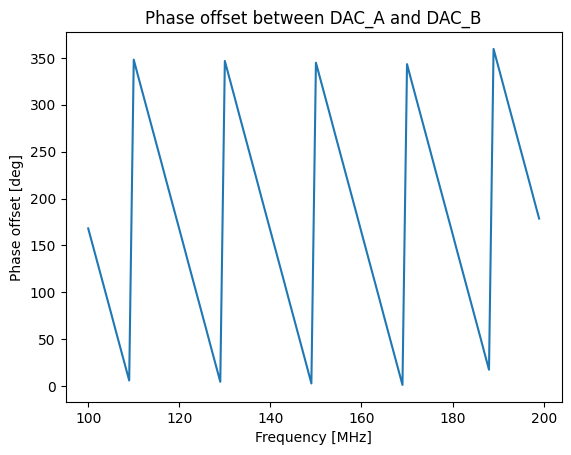

In [375]:
x,y = [], []
for key, value in adc_c_offsets.items():
    # print(f"{key}: {value[0]}")
    x.append(key)
    y.append(value)

# plt.plot(x,y, marker="s")
plt.plot(x,y)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Phase offset [deg]")
plt.title("Phase offset between DAC_A and DAC_B");

In [379]:
adc_offsets = {}

for freq in adc_c_offsets:
    adc_offsets[freq] = ((adc_c_offsets[freq] - adc_d_offsets[freq]) % 360) - 360
print(adc_offsets)

{100.00000991821288: -0.7826903863930283, 101.00000610351562: -0.773850436170278, 102.00000228881835: -0.7642150807838561, 102.99999847412109: -0.7494093873200995, 103.99999465942382: -0.7336269772407036, 104.99999084472655: -0.7236434708961497, 106.00000762939452: -0.7168030060607293, 107.00000381469725: -0.7067445013591396, 107.99999999999999: -0.6981052859673014, 108.99999618530272: -0.6882002676470051, 109.99999237060545: -0.6815757797771198, 111.00000915527343: -0.6766064809846739, 112.00000534057617: -0.6667712070907328, 113.0000015258789: -0.6596798987720263, 113.99999771118163: -0.6496822029601503, 114.99999389648437: -0.6440035901831607, 115.9999900817871: -0.6395109442321427, 117.00000686645507: -0.6287198797231213, 118.0000030517578: -0.6196193195947899, 118.99999923706054: -0.6160536042682452, 119.99999542236327: -0.6055779889691166, 120.999991607666: -0.5976291201528738, 122.00000839233397: -0.5910749511485847, 123.0000045776367: -0.5837359480775604, 124.00000076293944: -0

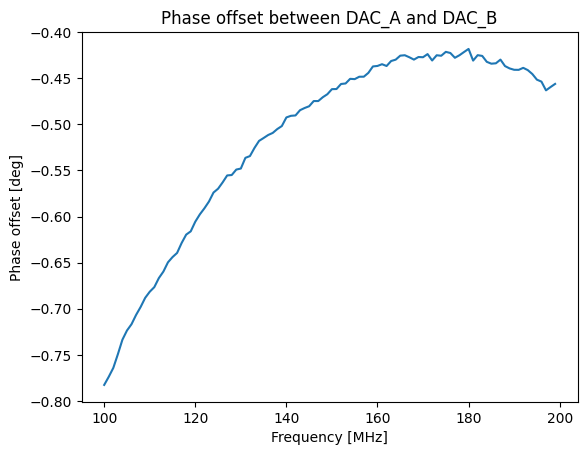

In [380]:
x,y = [], []
for key, value in adc_offsets.items():
    # print(f"{key}: {value[0]}")
    x.append(key)
    y.append(value)

# plt.plot(x,y, marker="s")
plt.plot(x,y)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Phase offset [deg]")
plt.title("Phase offset between DAC_A and DAC_B");

## Calibrate Phase

In [387]:
# change this from 10 to 1000
config['reps'] = 1000
delta_phis = {}

config['soft_avgs'] = 1
res=[]
# for f0 in f0_v:
for f0 in f0_v:
    config['pulse_freq'] = f0
    prog =SingleFreqProgram(soccfg, config)
    avg_data = prog.acquire(soc, progress=False)
    data = [[prog.di_buf[i]/config['readout_length'], prog.dq_buf[i]/config['readout_length']] for i in range(2)]
    res.append([calculate_phase(d) for d in data])
    delta_phis[f0] = [(res[-1][1][0] - res[-1][0][0] - adc_offsets[f0]) % 360, 0]
    print_results(res[-1])
fi_v=np.array([[a[0] for a in r] for r in res]).T
soc.reset_gens()

# print(res)
# adc_c_phi = res[0][1][0]
# adc_d_phi = res[0][0][0]
# adc_d_phi_corrected = adc_d_phi + adc_offset
# delta_phi = (adc_c_phi - adc_d_phi_corrected) % 360
# print(delta_phi)
print(delta_phis)

freq_i = 100.000010 MHz, phi_i = (144.81, 168.13) deg, mag = (867.85, 844.27), RMS = (0.60, 0.59) ADU
freq_i = 101.000006 MHz, phi_i = (122.99, 150.17) deg, mag = (867.50, 843.96), RMS = (0.57, 0.55) ADU
freq_i = 102.000002 MHz, phi_i = (101.17, 132.20) deg, mag = (867.10, 843.65), RMS = (0.28, 0.28) ADU
freq_i = 102.999998 MHz, phi_i = (79.35, 114.24) deg, mag = (866.65, 843.40), RMS = (0.61, 0.59) ADU
freq_i = 103.999995 MHz, phi_i = (57.52, 96.27) deg, mag = (866.08, 843.12), RMS = (0.34, 0.33) ADU
freq_i = 104.999991 MHz, phi_i = (35.69, 78.30) deg, mag = (865.84, 842.97), RMS = (0.40, 0.39) ADU
freq_i = 106.000008 MHz, phi_i = (13.53, 60.01) deg, mag = (865.48, 842.59), RMS = (0.50, 0.49) ADU
freq_i = 107.000004 MHz, phi_i = (351.70, 42.03) deg, mag = (865.21, 842.25), RMS = (0.24, 0.24) ADU
freq_i = 108.000000 MHz, phi_i = (329.85, 24.05) deg, mag = (864.67, 841.89), RMS = (0.44, 0.42) ADU
freq_i = 108.999996 MHz, phi_i = (308.01, 6.06) deg, mag = (864.40, 841.71), RMS = (0.35, 0

In [388]:
# to save the data
with open('pickles/calibrate_phase.pickle', 'wb') as handle:
    pickle.dump(delta_phis, handle, protocol=pickle.HIGHEST_PROTOCOL)

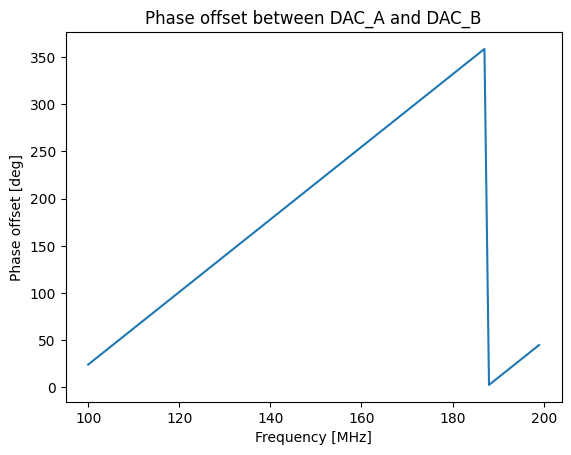

In [382]:
x,y = [], []
for key, value in delta_phis.items():
    # print(f"{key}: {value[0]}")
    x.append(key)
    y.append(value)

# plt.plot(x,y, marker="s")
plt.plot(x,y)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Phase offset [deg]")
plt.title("Phase offset between DAC_A and DAC_B");

24.0772 by hand

In [272]:
import time
prog =SingleFreqProgram(soccfg, config)
for i in range(1000):
    avg_data = prog.acquire(soc, progress=False)
    time.sleep(0.1)

DAC_A:1, DAC_B:2 - 24.91
DAC_A:2, DAC_B:1 - 23.13
Average: 24.02